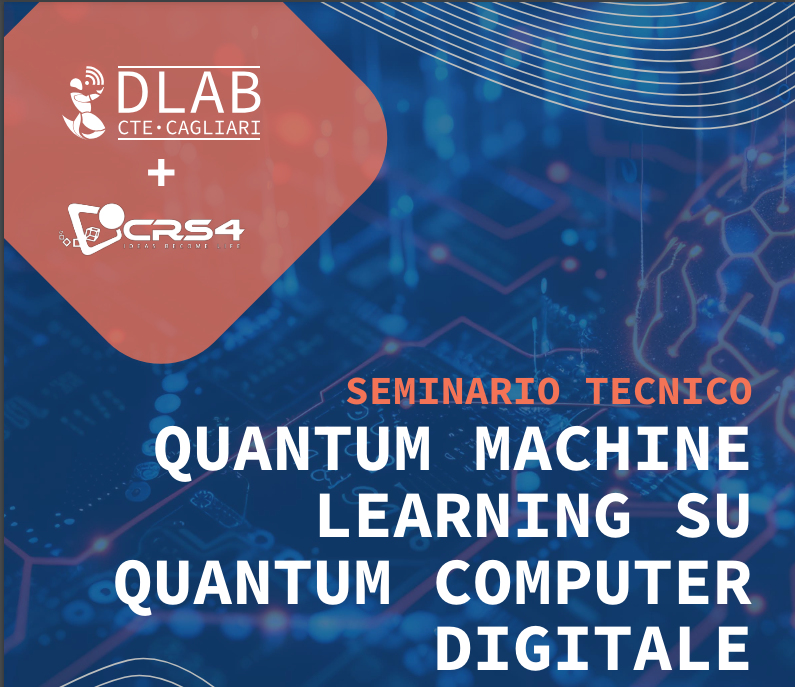

## Crediti

Il presente notebook è stato redatto da Giuliana Siddi Moreau del CRS4 nell'ambito delle esercitazioni pratiche dei seminari tecniche del Cagliari Digital Lab
Tale materiale formativo è stato redatto sulla base di:
* il dataset utilizzato in Mckinsey Analytics Online Hackathon, reperibile in https://www.kaggle.com/datasets/utathya/smart-city-traffic-patterns 
* Il notebook realizzato su kaggle da 
KAVYAN, reperibile in  https://www.kaggle.com/code/kavya2004/traffic-pattern-prediction-96
* Il materiale didattico di Qiskit Machine Learning https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02_neural_network_classifier_and_regressor.html
* l'eccellente ispirazione trovata nei lavori di Kevin Kawchak https://github.com/kevinkawchak

# Esercitazione pratica
Per trasformare la città in una smart city, occorre trasformarla in una città digitale e intelligente per migliorare l'efficienza dei servizi per i cittadini. Uno dei problemi che l'amministrazione comunale deve affrontare è il traffico. 
Ci siamo ispirati al caso d'uso presentato in kaggle 
Il governo vuole implementare un sistema di traffico solido per la città, preparandosi ai picchi di traffico. Vogliono capire i modelli di traffico dei quattro incroci della città. L'andamento del traffico nei giorni festivi, così come in altre occasioni durante l'anno, è diverso da quello dei normali giorni lavorativi. È importante tenerne conto per le previsioni.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./traffic_4_int1_quantum_4qubits.ipynb
./traffic_4_int1_quantum_3.ipynb
./train_aWnotuB.csv
./traffic_4_int1_quantum_old.ipynb
./test_BdBKkAj.csv
./.ipynb_checkpoints/traffic_4_int1_quantum_4qubits-checkpoint.ipynb
./.ipynb_checkpoints/traffic_4_int1_quantum_3-checkpoint.ipynb
./.ipynb_checkpoints/traffic_4_int1_quantum_old-checkpoint.ipynb


In [2]:
!pip install seaborn lightgbm xgboost pydantic sympy 

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached lightgbm-4.3.0-py3-none-manylinux_2_28_x86_64.whl.metadata (19 kB)
  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
  Using cached pydantic-2.7.0-py3-none-any.whl.metadata (103 kB)
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached scipy-1.13.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached annotated_types-0.6.0-py3-none-any.whl.metadata (12 kB)
  Using cached pydantic_core-2.18.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.5 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached lightgbm-4.3.0-py3-none-manylinux_2_28_x86_64.whl (3.1 MB)
Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)
Using cached pydantic-2.7.0-py3-none-any.whl (407 kB)
Using cached pydantic_core-2.18.1-cp39-cp39-many

In [3]:
from sklearn.decomposition import PCA

In [4]:
#importing required libraries 

import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import time
import seaborn as sns

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
import lightgbm as lgb
import xgboost as xgb

# Boosting Algorithm Libraries :
from sklearn.ensemble import RandomForestRegressor


In [5]:
test = pd.read_csv('test_BdBKkAj.csv')
train = pd.read_csv('train_aWnotuB.csv')

In [6]:
def data_inf(data,name):
    print('rows: ',data.shape[0],' ,columns: ',data.shape[1],' in',name,'\n')
    data.info()
    print('\n')
data_inf(train,'Train')


rows:  48120  ,columns:  4  in Train 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB




In [7]:
display(train.describe())
display(train.describe(include = 'object'))

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


,DateTime
count,48120
unique,14592
top,2017-03-02 06:00:00
freq,4


In [8]:
print('before dropping ',train.shape[0])
train.drop_duplicates(keep="first", inplace=True) 
print('after dropping ',train.shape[0])

before dropping  48120
after dropping  48120


In [9]:
if(train.isnull().sum().sum()==0):
    print('no missing values in train')
else:
    train.fillna(method='ffill',inplace=True)
if(test.isnull().sum().sum()==0):
    print('no missing values in test')    
else:
    test.fillna(method='ffill',inplace=True)

no missing values in train
no missing values in test


In [10]:
print('before converting :',train['DateTime'].dtype)
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])
print('after converting :',train['DateTime'].dtype)

before converting : object
after converting : datetime64[ns]


In [11]:
tr_mask=train['Junction'].isin([1])
train=train[tr_mask]
te_mask=test['Junction'].isin([1])
test=test[te_mask]

In [12]:
train.describe()

,DateTime,Junction,Vehicles,ID
count,14592,14592.0,14592.000000,1.459200e+04
mean,2016-08-30 23:30:00,1.0,45.052906,2.016260e+10
min,2015-11-01 00:00:00,1.0,5.000000,2.015110e+10
25%,2016-03-31 23:45:00,1.0,27.000000,2.016038e+10
50%,2016-08-30 23:30:00,1.0,40.000000,2.016083e+10
75%,2017-01-29 23:15:00,1.0,59.000000,2.017013e+10
max,2017-06-30 23:00:00,1.0,156.000000,2.017063e+10
std,NaN,0.0,23.008345,5.779594e+06


In [13]:
# Exploring more features  
train["Year"]= train['DateTime'].dt.year  
train["Month"]= train['DateTime'].dt.month  
train["Date_no"]= train['DateTime'].dt.day  
train["Hour"]= train['DateTime'].dt.hour  
train["Day"]= train.DateTime.dt.dayofweek


test["Year"]= test['DateTime'].dt.year  
test["Month"]= test['DateTime'].dt.month  
test["Date_no"]= test['DateTime'].dt.day  
test["Hour"]= test['DateTime'].dt.hour  
test["Day"]= test.DateTime.dt.dayofweek

In [14]:
test.describe()

,DateTime,Junction,ID,Year,Month,Date_no,Hour,Day
count,2952,2952.0,2.952000e+03,2952.0,2952.000000,2952.000000,2952.000000,2952.000000
mean,2017-08-31 11:30:00.000000256,1.0,2.017087e+10,2017.0,8.495935,15.878049,11.500000,3.000000
min,2017-07-01 00:00:00,1.0,2.017070e+10,2017.0,7.000000,1.000000,0.000000,0.000000
25%,2017-07-31 17:45:00,1.0,2.017073e+10,2017.0,7.000000,8.000000,5.750000,1.000000
50%,2017-08-31 11:30:00,1.0,2.017083e+10,2017.0,8.000000,16.000000,11.500000,3.000000
75%,2017-10-01 05:15:00,1.0,2.017100e+10,2017.0,10.000000,24.000000,17.250000,5.000000
max,2017-10-31 23:00:00,1.0,2.017103e+10,2017.0,10.000000,31.000000,23.000000,6.000000
std,NaN,0.0,1.124808e+05,0.0,1.121847,8.878793,6.923359,2.020565


/tmp/ipykernel_797/1829596167.py:4: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  time_series=sns.lineplot(x=train['DateTime'],y="Vehicles",data=train, hue="Junction", palette=colors)


Text(0.5, 0, 'DateTime')

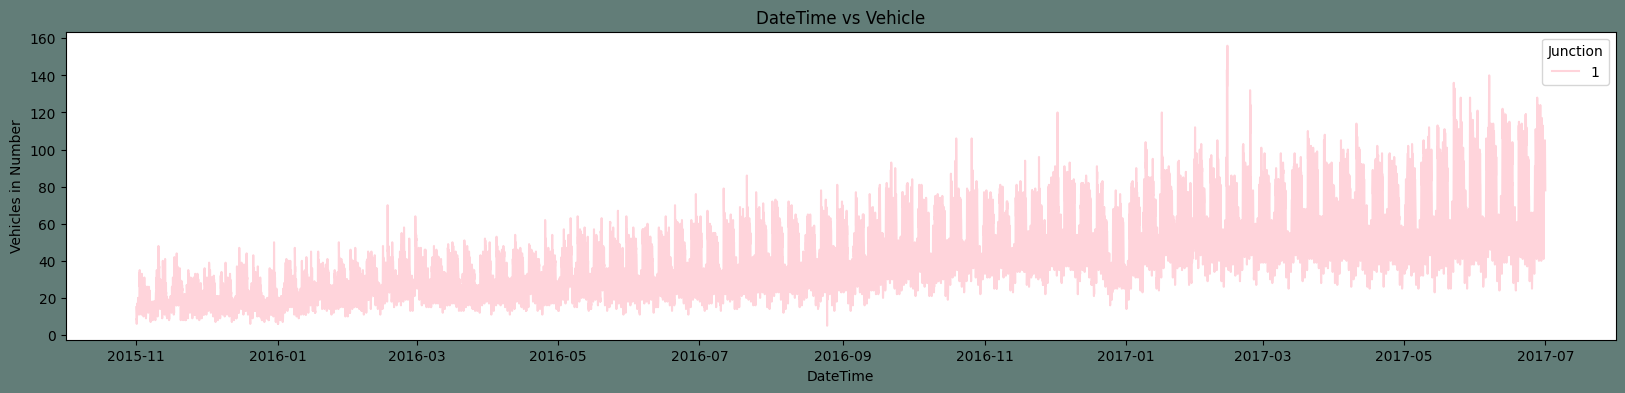

In [15]:
# time series plot
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")  
time_series=sns.lineplot(x=train['DateTime'],y="Vehicles",data=train, hue="Junction", palette=colors)  
time_series.set_title("DateTime vs Vehicle")  
time_series.set_ylabel("Vehicles in Number")  
time_series.set_xlabel("DateTime") 

/tmp/ipykernel_797/2121896102.py:4: UserWarning: The palette list has more values (4) than needed (1), which may not be intended.
  count = sns.countplot(data=train, x =train["Year"], hue="Junction", palette=colors)


Text(0.5, 0, 'Date')

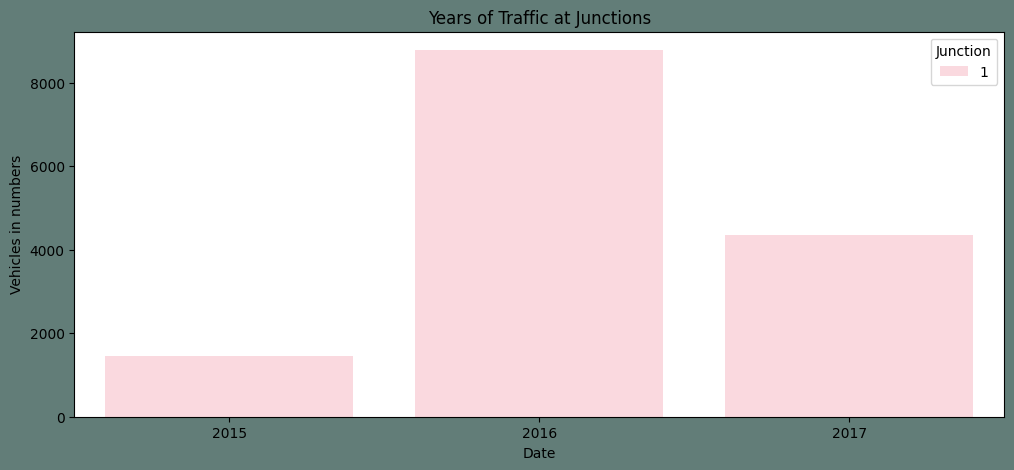

In [16]:
#years of traffic at junction
plt.figure(figsize=(12,5),facecolor="#627D78")  
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
count = sns.countplot(data=train, x =train["Year"], hue="Junction", palette=colors)  
count.set_title("Years of Traffic at Junctions")  
count.set_ylabel("Vehicles in numbers")  
count.set_xlabel("Date") 


<Axes: >

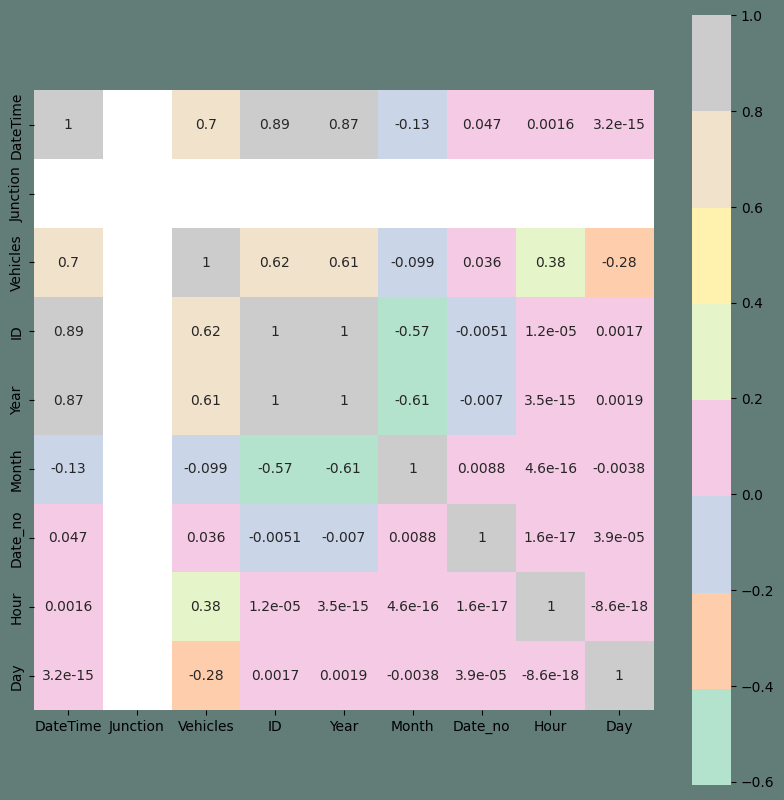

In [17]:
#heat map
corrmat = train.corr()  
plt.subplots(figsize=(10,10),facecolor="#627D78")  
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True, )  



In [18]:
def datetounix1(df):
    # Initialising unixtime list
    unixtime = []
    
    # Running a loop for converting Date to seconds
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['DateTime'] = unixtime
    return(df)

In [19]:
#train_features = datetounix1(train.drop(['Vehicles', 'Junction'], axis=1))
train_features = datetounix1(train)
test_features = datetounix1(test)


# Store Features / Predictors in array :
X = train_features  
X_valid = test_features

# One Hot Encoding - Using Dummies :
#X = pd.get_dummies(X)
#X_valid = pd.get_dummies(X_valid)

# Store target 'Vehicles' in y array :
y = train['Vehicles'].to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=512)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 590
[LightGBM] [Info] Number of data points in the train set: 9776, number of used features: 7
[LightGBM] [Info] Start training from score 44.751944
Mean Squared Error: 19.184953271759433
Mean Absolute Error: 3.047306743177696
R2 Score: 0.9644295353898664

Random Forest regressor 
ean Squared Error: 17.23255269933555
Mean Absolute Error: 2.9512832225913623
R2 Score: 0.9680494449347302

In [20]:
print(X_train)

           DateTime  Junction  Vehicles           ID  Year  Month  Date_no  \
8681   1.477588e+09         1        67  20161027171  2016     10       27   
4959   1.464188e+09         1        50  20160525151  2016      5       25   
5334   1.465538e+09         1        23  20160610061  2016      6       10   
10479  1.484060e+09         1        84  20170110151  2017      1       10   
8881   1.478308e+09         1        48  20161105011  2016     11        5   
...             ...       ...       ...          ...   ...    ...      ...   
1181   1.450588e+09         1         6  20151220051  2015     12       20   
3309   1.458248e+09         1        41  20160317211  2016      3       17   
8552   1.477123e+09         1        29  20161022081  2016     10       22   
12041  1.489684e+09         1        79  20170316171  2017      3       16   
13217  1.493917e+09         1        89  20170504171  2017      5        4   

       Hour  Day  
8681     17    3  
4959     15    2  
5334  

In [21]:
import pandas as pd
from sklearn import preprocessing

from sklearn.decomposition import PCA
pca = PCA(n_components=4) # vogliamo proiettare due dimensioni in modo da poterle visualizzare!

# Addestriamo il modello PCA sui dati standardizzati
pca_features = pca.fit_transform(train_features)

pca_features_quantum = pd.DataFrame(pca_features)

pca_features_quantum.describe()

,0,1,2,3
count,1.459200e+04,1.459200e+04,1.459200e+04,1.459200e+04
mean,-3.952729e-07,-1.137570e-06,-6.771971e-14,3.493658e-13
std,1.603490e+07,2.502426e+06,1.695136e+01,8.738875e+00
min,-2.744322e+07,-4.544018e+06,-4.765143e+01,-1.645763e+01
25%,-1.487732e+07,-2.108076e+06,-1.245419e+01,-7.490414e+00
50%,5.825052e+05,-1.854917e+05,-1.561405e+00,-2.932894e-02
75%,1.313072e+07,2.353829e+06,1.255262e+01,7.497797e+00
max,2.858520e+07,4.789064e+06,9.453454e+01,1.714952e+01


In [22]:
x = pca_features_quantum.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
train_features_quantum = pd.DataFrame(x_scaled)
min_max_scaler = preprocessing.MinMaxScaler()
y_scaled = min_max_scaler.fit_transform(y.values)
y_quantum = pd.DataFrame(y_scaled)

In [23]:
train_features_quantum.describe()

,0,1,2,3
count,14592.000000,14592.000000,14592.000000,14592.000000
mean,0.489809,0.486872,0.335135,0.489706
std,0.286192,0.268124,0.119220,0.260030
min,0.000000,0.000000,0.000000,0.000000
25%,0.224277,0.261001,0.247544,0.266825
50%,0.500205,0.466998,0.324153,0.488833
75%,0.724167,0.739075,0.423418,0.712807
max,1.000000,1.000000,1.000000,1.000000


In [24]:
y_quantum.describe()

,0
count,14592.000000
mean,0.265251
std,0.152373
min,0.000000
25%,0.145695
50%,0.231788
75%,0.357616
max,1.000000


In [25]:
X=train_features_quantum
X_train_q, X_test_q, y_train_q, y_test_q = train_test_split(X, y_quantum, test_size=0.33, random_state=512)

In [26]:
print (X_train_q.values)

[[0.41498263 0.82195813 0.45965477 0.78671252]
 [0.64377217 0.40051811 0.43577022 0.77929414]
 [0.62051956 0.43950549 0.22578032 0.33142028]
 ...
 [0.42283994 0.80610603 0.18783862 0.64397096]
 [0.15657184 0.30837135 0.45191197 0.50189154]
 [0.08411119 0.43855619 0.4896874  0.12819648]]


In [27]:
from IPython.display import clear_output
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [28]:
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, POWELL
from qiskit_machine_learning.circuit.library import QNNCircuit
# construct simple feature map
#param_x = Parameter("x")
#feature_map = QuantumCircuit(7, name="fm")
#feature_map.ry(param_x, 0)
from qiskit.circuit.library import ZZFeatureMap
features=X_train_q.values

num_features = features.shape[1]


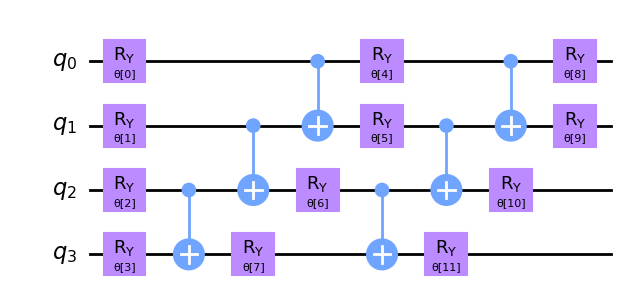

In [29]:
from qiskit.circuit.library import RealAmplitudes
ansatz_4 = RealAmplitudes(4, reps=2)
ansatz_4.decompose().draw(output="mpl", style="clifford", fold=20)

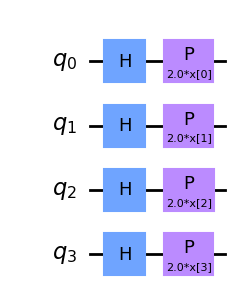

In [30]:
from qiskit.circuit.library import ZFeatureMap

feature_map= ZFeatureMap(4, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)


In [31]:
#param_y = Parameter("y")
#ansatz = QuantumCircuit(7, name="vf")
#ansatz.ry(param_y, 0)
X_q=X_train_q.values
y_q=y_train_q.values
X_te_q=X_test_q.values
y_te_q=y_test_q.values

print(X_q.shape)
#X_q=np.reshape(X_q,(9776,4))
#print(X_q.shape)
X_train_q.describe()

print(X_te_q.shape)
te_shape=X_te_q.shape[0]
#X_te_q=np.reshape(X_te_q,(te_shape,4))
#print(X_te_q.shape)
X_test_q.describe()


(9776, 4)
(4816, 4)


,0,1,2,3
count,4816.000000,4816.000000,4816.000000,4816.000000
mean,0.485160,0.486334,0.337778,0.491083
std,0.284769,0.265784,0.119951,0.258622
min,0.000364,0.000881,0.011954,0.000000
25%,0.224338,0.261953,0.248498,0.270609
50%,0.495629,0.472958,0.327798,0.488768
75%,0.717457,0.734216,0.426930,0.711714
max,0.999818,1.000000,0.902992,1.000000


In [32]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
# construct simple feature map
param_x = Parameter("x")
#feature_map = QuantumCircuit(1, name="fm")
#feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
#ansatz = QuantumCircuit(1, name="vf")
#ansatz.ry(param_y, 0)

In [34]:
# construct a circuit
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz_4)

# construct QNN
regression_estimator_qnn = EstimatorQNN(circuit=qc)
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=POWELL(),
    callback=callback_graph,
)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

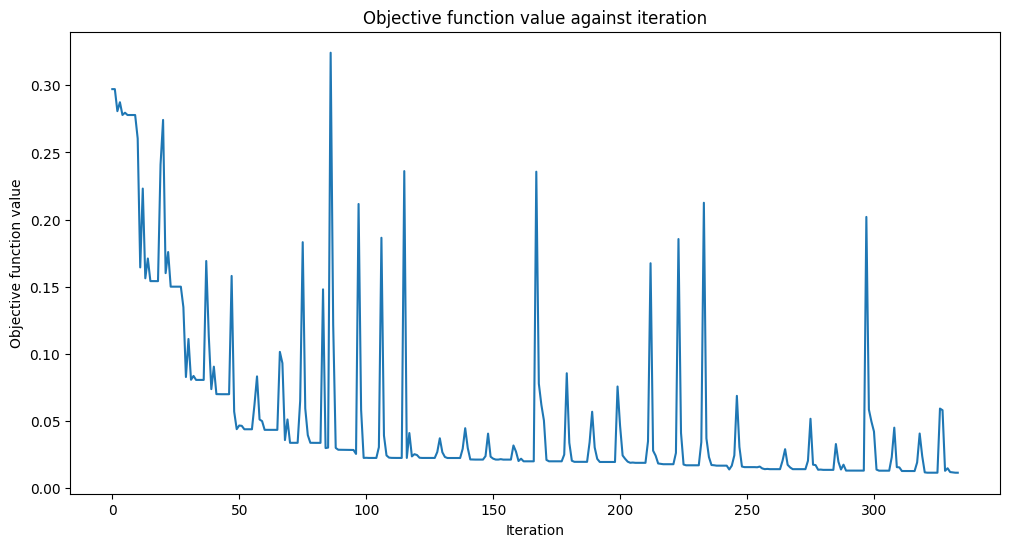

In [ ]:
# fit to data
y_q=y_train_q.values
regressor.fit(X_q, y_q)

In [ ]:
y_te_q=y_test_q.values

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result

regressor.score(X_q, y_q)

In [ ]:
y_te_q_r=regressor.predict(X_te_q)

In [ ]:
mse = mean_squared_error(y_te_q, y_te_q_r)
mae = mean_absolute_error(y_te_q, y_te_q_r)
r2 = r2_score(y_te_q, y_te_q_r)

# Printing the evaluation metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

In [ ]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz_4,
    optimizer=POWELL(maxiter=5),
    callback=callback_graph,
)

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X_te_q, y_te_q)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(X_te_q, y_te_q)
